In [6]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
class LSTMEncoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTMEncoder, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, 
                            batch_first = True)
        
        nn.init.orthogonal_(self.lstm.weight_ih_l0, gain = np.sqrt(2))
        nn.init.orthogonal_(self.lstm.weight_hh_l0, gain = np.sqrt(2))
        
    def forward(self, x):
        device = x.device
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(1, x.size(0), self.hidden_size).to(device)
        
        out, _ = self.lstm(x, (h0, c0))
        return out

In [8]:
class LSTMAttentionDecoder(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(LSTMAttentionDecoder, self).__init__()
        
        self.lstm = nn.LSTMCell(hidden_size, hidden_size)
        self.softmax = nn.Softmax(dim = 1)
        self.attention_fc = nn.Linear(2 * hidden_size, 1)
        self.bbox_fc = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        
        nn.init.orthogonal_(self.lstm.weight_ih, gain = np.sqrt(2))
        nn.init.orthogonal_(self.lstm.weight_hh, gain = np.sqrt(2))

        self.alphas_seq = []
    
    def forward(self, x):
        device = x.device
        batch_size, seq_length, hidden_size = x.size()
        
        self.alphas_seq = []
        bboxs = []
        for ti in range(seq_length):
            if ti == 0:
                prev_h = torch.zeros(batch_size, hidden_size).to(device)
                prev_c = prev_h.clone().to(device)
            else:
                prev_h = crt_h
                prev_c = crt_c
            
            # (batch_size, seq_length, 2 * hidden_size)
            context = torch.cat([
                prev_h.unsqueeze(1).expand(-1, seq_length, -1), 
                x
            ], dim = -1) 
            out_fcs = self.attention_fc(context)
            # (batch_size, seq_length, 1)
            alphas = self.softmax(out_fcs)
            # (batch_size, seq_length, hidden_size)
            input_ti = (alphas * x).sum(dim = 1)
            self.alphas_seq.append(alphas.clone())
            
#             alphas = torch.zeros(batch_size, seq_length, 1).to(device)
#             alphas[:, ti, :] = 1.
#             input_ti = (alphas * x).sum(dim = 1)
#             self.alphas_seq.append(alphas.clone())

            # feed decoder input to decoder at timestep ti
            crt_h, crt_c = self.lstm(input_ti, (prev_h, prev_c))
            bbox_ti = self.bbox_fc(crt_h)
            bbox_ti = self.relu(bbox_ti)
            bboxs.append(bbox_ti)
            
        bboxs = torch.stack(bboxs, dim = 1)
        return bboxs

In [9]:
class LSTMAutoEncoder_withAttention(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTMAutoEncoder_withAttention, self).__init__()
        self.encoder = LSTMEncoder(
            input_size, hidden_size
        )
        self.decoder = LSTMAttentionDecoder(
            hidden_size, input_size
        )
        
    def forward(self, x):
        encoded_x = self.encoder(x)
        decoded_x = self.decoder(encoded_x)
        return decoded_x

In [10]:
device = torch.device('cuda')

hidden_size = 128
seq_length = 12
batch_size = 8
loading = 1.

# (batch, seq, [x, y, w, h])
x = torch.randint(low = 10, high = 320, 
                  size = (batch_size, seq_length, 4)
                 ).float()
x = x / 320.
#x = torch.randn(batch_size, seq_length, 4) * loading
x = x.to(device)

model = LSTMAutoEncoder_withAttention(
            input_size = 4, hidden_size = hidden_size
        )
model.to(device)

L2_loss = nn.MSELoss()
L1_loss = nn.L1Loss()

#optimizer = torch.optim.SGD(model.parameters(), lr = 0.1)
lr = 0.1
enc_optimizer = torch.optim.SGD(
    params = filter(lambda p: p.requires_grad, model.encoder.parameters()),
    lr = lr / 10.
)
dec_optimizer = torch.optim.SGD(
    params = filter(lambda p: p.requires_grad, model.decoder.parameters()),
    lr = lr
)

In [11]:
# NO reverse 
# L2 loss

# IoU
epoch_n = 5000

model.train()
losses = []
for epoch in range(epoch_n):    
    
    enc_optimizer.zero_grad()
    dec_optimizer.zero_grad()
    
    seq_length = x.size(1)
    outputs = model(x)
    
    #inv_idx = torch.arange(seq_length -1, -1, -1).long()
    #x[:, inv_idx, :] / outputs
    #loss = L1_loss(outputs, x[:, inv_idx, :])
    
    # RMSE
    loss = L2_loss(outputs, x)
    loss = torch.sqrt(loss)
    
#     loss = L1_loss(
#         torch.log(outputs),
#         torch.log(x[:, inv_idx, :])
#     )
    losses.append(loss)
    
    loss.backward()
    enc_optimizer.step()
    dec_optimizer.step()
    
    #print(f'[Epoch: {epoch}] Loss: {loss}')

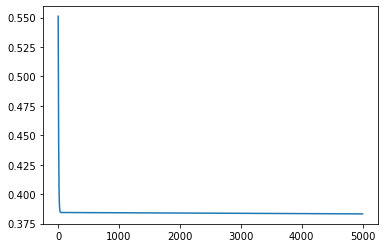

In [12]:
plt.plot(losses);

In [15]:
model.decoder.alphas_seq[-3][0]

tensor([[0.0835],
        [0.0832],
        [0.0830],
        [0.0835],
        [0.0836],
        [0.0836],
        [0.0832],
        [0.0835],
        [0.0832],
        [0.0832],
        [0.0831],
        [0.0835]], device='cuda:0', grad_fn=<SelectBackward>)